Random Forest Model

In [9]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
df=pd.read_csv("Data\label_encoded_dataset.csv")
df.head()

,age,workclass,fnlwgt,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,6,77516,9,4,0,1,4,1,2174,0,40,38,0
1,50,5,83311,9,2,3,0,4,1,0,0,20,38,0
2,38,3,215646,11,0,5,1,4,1,0,0,40,38,0
3,53,3,234721,1,2,5,0,2,1,0,0,40,38,0
4,28,3,338409,9,2,9,5,2,0,0,0,40,4,0


In [11]:
# Splitting the dataset into training and testing sets
x = df.drop('income', axis=1)
y = df['income']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
from imblearn.over_sampling import SMOTE
# Apply SMOTE to the training set only
smote = SMOTE(random_state=42)
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

1st Try using RF

In [19]:
# Initialize and train the Random Forest classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(x_train_smote, y_train_smote)

# Make predictions on the testing data
y_prediction = rf_model.predict(x_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_prediction)
report = classification_report(y_test, y_prediction)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)


Accuracy: 0.8281364829396326
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.88      0.89      7170
           1       0.65      0.67      0.66      2355

    accuracy                           0.83      9525
   macro avg       0.77      0.78      0.77      9525
weighted avg       0.83      0.83      0.83      9525



In [20]:
# Training accuracy
training_accuracy = rf_model.score(x_train, y_train)
print("Training Accuracy:", training_accuracy)

# Testing accuracy
testing_accuracy = rf_model.score(x_test, y_test)
print("Testing Accuracy:", testing_accuracy)

Training Accuracy: 0.9992387652246955
Testing Accuracy: 0.8281364829396326


In [21]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_prediction)

# Print the confusion matrix in text form
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[6306  864]
 [ 773 1582]]


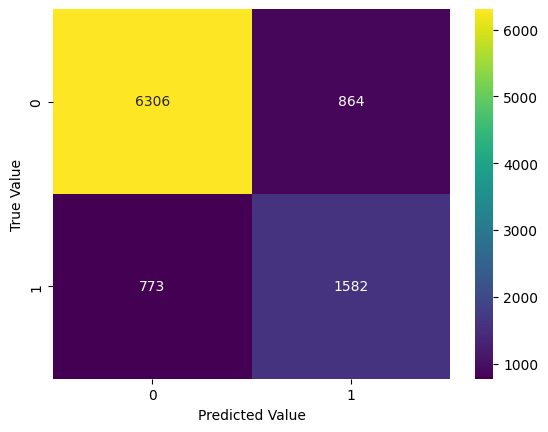

In [22]:
# Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_prediction), annot=True, cmap='viridis', fmt='d')
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.show()

Training Accuracy is high and shows signs of overfitting

Optimizing grid parameters

In [12]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20],      # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]     # Minimum number of samples required at each leaf node
}

# Initialize the Random Forest classifier
rf_model_2 = RandomForestClassifier(random_state=42)

# Initialize Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf_model_2, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Perform Grid Search to find the best parameters
grid_search.fit(x_train, y_train)

# Get the best parameters and the best accuracy
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Accuracy:", best_accuracy)



Best Parameters: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best Accuracy: 0.8551028389793578


In [13]:
# Use the best parameters to train the final model
final_rf_model = RandomForestClassifier(random_state=42, **best_params)
final_rf_model.fit(x_train, y_train)

# Make predictions on the testing data
y_prediction = final_rf_model.predict(x_test)

# Make predictions on the training data
y_train_prediction = final_rf_model.predict(x_train)

# Evaluate the model
accuracy = accuracy_score(y_test, y_prediction)

# Evaluate the model on the training data
training_accuracy = accuracy_score(y_train, y_train_prediction)

report = classification_report(y_test, y_prediction)

print("\nTraining Accuracy with Best Parameters:", training_accuracy)
print("\nTesting Accuracy with Best Parameters:", accuracy)
print("Classification Report with Best Parameters:\n", report)


Training Accuracy with Best Parameters: 0.8903821923561529

Testing Accuracy with Best Parameters: 0.8545931758530184
Classification Report with Best Parameters:
               precision    recall  f1-score   support

           0       0.88      0.94      0.91      7170
           1       0.76      0.60      0.67      2355

    accuracy                           0.85      9525
   macro avg       0.82      0.77      0.79      9525
weighted avg       0.85      0.85      0.85      9525



Confusion Matrix:
[[6725  445]
 [ 940 1415]]


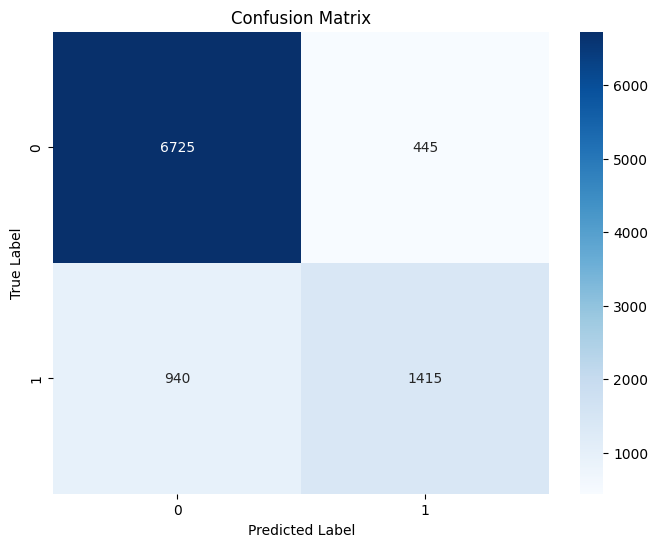

In [14]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_prediction)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)


# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()



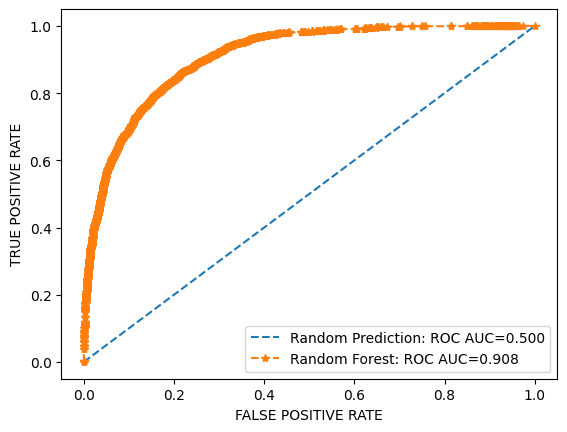

In [15]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Predict probabilities
rf_probs = final_rf_model.predict_proba(x_test)
rf_probs1 = rf_probs[:, 1]  # Keep probabilities for the positive outcome only

# Calculate AUC scores
ns_auc = roc_auc_score(y_test, [0 for _ in range(len(y_test))])
rf_auc = roc_auc_score(y_test, rf_probs1)

# Calculate ROC curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, [0 for _ in range(len(y_test))])
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs1)

# Plot the ROC curve
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Random Prediction: ROC AUC=%.3f' % ns_auc)
plt.plot(rf_fpr, rf_tpr, linestyle='--', marker='*', label='Random Forest: ROC AUC=%.3f' % rf_auc)
plt.xlabel('FALSE POSITIVE RATE')
plt.ylabel('TRUE POSITIVE RATE')
plt.legend()
plt.show()
